# Bayesian Optimization
![alt text](../images/OB1DSample.gif)
Ever thought about an automatic way to tune hyperparameters of your beloved machine learning algorithm? for example learning rate, weight decay, and drop out probability in a neural network? here we will look through a proposed way to achive a set of *good* hyperparameters by bayesian means.
In Bayesian Optimization (BO) a machine learning algorithem can be looked as a blackbox which gives out some measure of performance, e.g accuracy, accuracy per second, or any other score value that change relative to a set of parameters. 
By the end of this jupyter notebook we will utilize BO to get optimized parameters for a minimalistic network to learn digit handwriting recognition from MNIST dataset. 

It is recommended to go through my notebook on [**gaussian process regression**](../GaussianProcesses/GRP.ipynb) before progressing with material presented here.

I will use TensorFlow for neural network implementation and it is good if you go through [**this tutorial**](https://www.tensorflow.org/tutorials/mnist/beginners/) if you have no previous experience with this framework. 

For an all-in-one Docker image containig major deep learning frameworks consider [**this repository**](https://github.com/floydhub/dl-docker). 
#### Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


from scipy.linalg import det
from scipy.linalg import pinv2 as inv #pinv uses linalg.lstsq algorithm while pinv2 uses SVD
from scipy.stats import norm


%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


We will begin by a simple 1D optimization problem for a function that we dont know the closed form of it (for presentation purposes we will know thee analytic optimum point of our function). Then we will try with a 2D function and finally we will apply our be then prepared tools in a real neural network case. Let's begin with our fun! but first we need our building parts.

# GP Tools
Here we will include code for all the GP tools that we will use further in the notebook. For closer explanation you can see my notebook on [**gaussian process regression**](../GaussianProcesses/GRP.ipynb).

In [2]:
# %load GPR.py
# GP squared exponential with its own hyperparameters
def get_kernel(X1,X2,sigmaf,l,sigman):
    k = lambda x1,x2,sigmaf,l,sigman:(sigmaf**2)*np.exp(-(1/float(2*(l**2)))*np.dot((x1-x2),(x1-x2).T)) + (sigman**2);
    K = np.zeros((X1.shape[0],X2.shape[0]))
    for i in range(0,X1.shape[0]):
        for j in range(0,X2.shape[0]):
            if i==j:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,sigman);
            else:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,0);
    return K

# finding optimized parameters for GP by maximizing closed-form log p(y|x,theta)
def fit_GP(x,y, gp_params):
    # log p(y|x,theta) = 0.5y'K^-1y-0.5log|K|-0.5nlog2pi
    # sigman > measurement noise
    # sigmaf > maximum covariance value
    # l > lenght-scale of our GP with squared exponential kernel
    
    bounds = [(0.001,2),(0.001,1),(0.001,1)]
    logpxtheta = lambda p: 0.5*(np.dot(y.T,np.dot(inv(get_kernel(x,x,p[0],p[1],p[2])),y)) + np.log(det(get_kernel(x,x,p[0],p[1],p[2]))) + x.shape[0]*np.log(2*np.pi)).reshape(-1,1)[0];
    
    res = minimize(fun=logpxtheta,
                       x0=gp_params,
                       bounds=bounds,
                       method='L-BFGS-B')
    new_gp_params = res['x']
    #print 'new GP parameters', new_gp_params
    return new_gp_params

#putting everything about GP to use here
def GPR(x_predict,x,y,gp_params):

    pdim = x_predict.shape[0]

    sigmaf, l, sigman = gp_params

    K = get_kernel(x, x, sigmaf, l, sigman)
    K_s = get_kernel(x_predict, x, sigmaf, l, 0)
    K_ss = get_kernel(x_predict, x_predict, sigmaf, l, sigman)

    #print K.shape,K_s.shape, K_ss.shape, y.shape
    y_predict_mean = np.dot(np.dot(K_s,inv(K)),y).reshape(pdim,-1)
    y_predict_var = np.diag(K_ss - np.dot(K_s,(np.dot(inv(K),K_s.T))))#.reshape(-1,1)
    #print y_predict_mean.shape
    return (y_predict_mean, y_predict_var)

## Acquisition Function
With acquisition function we determine where to sample next from our GP prior to best achieve our optimization objective. This functions yields an automatic optimized choice between exploration (where GP posterior variance is high) and exploitation (where the mean of GP is high). We will choose new set of parameters where exploitation is high (high GP mean) and also exploration is high (high GP uncertainty).

Different options exist for the choice of acquisition fucntion:
- Expected improvement: $a_{EI}(x,\{x_n,y_n\},\theta) = \sigma_{GP}(x,\{x_n,y_n\},\theta)\left[\gamma(x)\Phi\left(\gamma(x)\right) + \mathcal{N}(\gamma(x); 0, 1)\right]$

where

$\gamma(x)=\frac{f(x_{best}) - \mu_{GP}(x,\{x_n,y_n\},\theta)}{\sigma_{GP}(x,\{x_n,y_n\},\theta)}$ 

_$\Phi$ is the normal cumulative distribution and $x_{best}$ is the location of the lowest posterior mean._

In conlusion, each time we get new observed point the question is where to look next to get the optimum (here assume maximum) point in the underlying unseen function; and by finding the optimum point (min or max) of an acquizition function we will choose between exploitation/exploration dillema. The good thing about EI acquisition function is that, it has no parameter of itself and the choice is automatic for optimum point which will be the next point of sampling from the undelying function. Further on we will use LBFGS algorithem to find the min of the acquisition function (or negative of ac function for its maximum) but this can be also part of the OB itself.

In [3]:
def expected_improvement(x, xp, yp, gp_params, kappa=0.0, n_params = 1):
    
    xpredict = np.asarray(x).reshape(-1, n_params)

    GP_mu, GP_sigma = GPR(xpredict, xp, yp, gp_params)
    GP_sigma = GP_sigma.reshape(-1,1)
    f_best = np.max(yp)

    #print n_params, xp.shape,yp.shape,xpredict.shape
    with np.errstate(divide='ignore'):
        gamma_x = (GP_mu - f_best) / GP_sigma 
        EIx = GP_sigma * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))
        EIx[GP_sigma == 0.0] == 0
    return -1*EIx # negative because we will use a minimizer to find the maximum

def upper_confidence_bound(x, xp, yp, gp_params, kappa=0.0, n_params = 1):
    xpredict = np.asarray(x).reshape(-1, n_params)
    GP_mu, GP_sigma = GPR(xpredict, xp, yp, gp_params)
    GP_sigma = GP_sigma.reshape(-1,n_params)
    return -1*(GP_mu + kappa * GP_sigma)

In [4]:
def sample_next_hyperparameter(acquisition_func, xp, yp, gp_params, bounds, kappa=0.0, n_restarts=10):
    '''n_restarts: integer.
            Number of times to run the minimizer with different starting points.'''
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]
    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):
        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(-1, n_params),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(xp,yp, gp_params,kappa, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

## Shall Optimize!


In [5]:
def BayesianOptimization(f, bounds,max_iter=10,n_pre_samples=2,
                         gp_params=(0.5, 1., 0.001),
                         fit_GP_every=0,dis_every=1,plot_res = 0, kappa = 0.0):
    x_list = []
    y_list = []
    
    n_param = bounds.shape[0]
    
    #randomly sample the function to be optimized
    for j, params in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0]))):
        x_list.append(params)
        y_list.append(f(params))
        #if dis_every and i%dis_every==0: print 'Generating sample %d ...'%i

    xp = np.array(x_list)
    yp = np.array(y_list)

    for i in range(max_iter):
        
        if fit_GP_every and i%fit_GP_every==0: gp_params =  fit_GP(xp,yp, gp_params) # sigmaf, l, sigman

        next_sample = sample_next_hyperparameter(expected_improvement, xp, yp,gp_params, bounds=bounds,n_restarts=20)
        #next_sample = sample_next_hyperparameter(upper_confidence_bound, xp, yp,gp_params, bounds=bounds,kappa=kappa)

        # avoid very close points
        while np.any(np.abs(next_sample - xp) <= np.finfo(float).eps):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        cv_score = f(next_sample)

        # save previous values for plotting
        prev_xp = xp
        prev_yp = yp
        
        # Updates
        x_list.append(next_sample)
        y_list.append(cv_score)

        xp = np.array(x_list)
        yp = np.array(y_list)

        if dis_every and i%dis_every==0: 
            print 'Iter. # %d - Best Results: '%(i+1),
            for j,val in enumerate(next_sample):
                #print 'parameter_%d = %2.2f,'%(j,val),
                print 'parameter_%d = %2.2f,'%(j+1,xp[np.argmax(yp),j]),
            print ' val=%2.2f'%max(yp)
            if plot_res:
                if xp.shape[1] == 1: # 2D plots
                    fig = plt.figure(figsize=(8,8))
                    param_choices = np.arange(bounds[0,0],bounds[0,1],0.1).reshape(-1,xp.shape[1])
                    y_mean, y_std = GPR(param_choices, prev_xp, prev_yp, gp_params)

                    EIx = -expected_improvement(param_choices, prev_xp, prev_yp, gp_params, n_params = 1)
                    #EIx = -upper_confidence_bound(param_choices, prev_xp, prev_yp, gp_params,kappa, n_params = 1)
                    EIxnorm=np.linalg.norm(EIx)
                    if EIxnorm!=0: EIx = EIx/EIxnorm # normalizing for beter visualiation
                    plt.plot(param_choices[:,0], 2*EIx[:,0],'m')

                    plt.plot(next_sample,f(next_sample),'ro')

                    plt.plot(param_choices[:,0],f(param_choices[:,0]),'k--')
                    plt.plot(prev_xp,prev_yp,'b*')

                    plt.plot(param_choices[:,0], y_mean[:,0],'b')
                    plt.fill_between(param_choices[:,0], y_mean[:,0]-y_std,y_mean[:,0]+y_std,alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
                    plt.title('Iter. #%2d best val so far is %2.2f'%(i+1,max(yp)))
                    plt.ylim([-1.5,2])
                    fig.savefig('tmp_BO_%d.png'%i)
                    plt.show()
                else: print 'High dimensional plots not yet implemented!'
    best_params = []
    print 'Iterations Done... Best Result: ',
    for j in range(xp.shape[1]):
        print 'parameter_%d = %2.2f,'%(j+1,xp[np.argmax(yp),j]),
        best_params.append(xp[np.argmax(yp),j])
    print 'which yiels %2.5f !!'%max(yp)
    return tuple(best_params),max(yp)

## 1D Bayesian Optimization
We run BO on our toy 1D function and see that the found max is close to the true maximum of our function

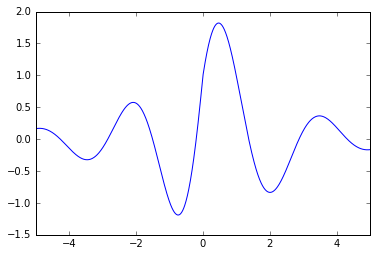

real func max is: 1.821


In [6]:
#sample function definiton
f = lambda x: np.exp(-abs(x))*np.cos(0.5*np.pi*x)+2*np.exp(-0.5*abs(x))*np.sin(0.7*np.pi*x)
x = np.linspace(-5,5,1000)
y = f(x)
plt.plot(x,y)
plt.axis([-5, 5, -1.5, 2])
plt.show()
print 'real func max is: %2.3f'%np.max(y)

Let's see how our BO solves this maximization problem.

_You might need to run it couple of times to get the best result, this strategy is not deterministic_

In [7]:
x,y = BayesianOptimization(f, bounds=np.array([[-5,5]]),
                           max_iter=10, n_pre_samples=2, 
                           gp_params=(0.6, .8, 0.001),fit_GP_every=0,
                           dis_every=1,plot_res = 0,kappa = 0)

Iter. # 1 - Best Results:  parameter_1 = 2.92,  val=0.06
Iter. # 2 - Best Results:  parameter_1 = 1.26,  val=0.27
Iter. # 3 - Best Results:  parameter_1 = 0.03,  val=1.09
Iter. # 4 - Best Results:  parameter_1 = 0.03,  val=1.09
Iter. # 5 - Best Results:  parameter_1 = 0.03,  val=1.09
Iter. # 6 - Best Results:  parameter_1 = 0.40,  val=1.80
Iter. # 7 - Best Results:  parameter_1 = 0.48,  val=1.82
Iter. # 8 - Best Results:  parameter_1 = 0.48,  val=1.82
Iter. # 9 - Best Results:  parameter_1 = 0.48,  val=1.82
Iter. # 10 - Best Results:  parameter_1 = 0.48,  val=1.82
Iterations Done... Best Result:  parameter_1 = 0.48, which yiels 1.82035 !!


## 2D Bayesian Optimization
BO on a 2D space with an imaginary function.

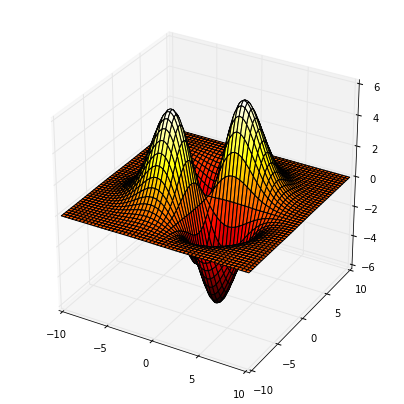

real func max is: 5.851


In [16]:
# we define a function here and visualize it
from mpl_toolkits.mplot3d import axes3d #it has to be imported

size = 500
sigma_x = 2.5
sigma_y = 2.5

f2 = lambda p: 10000*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(p[0]**2/(2*sigma_x**2) + p[1]**2/(2*sigma_y**2)))*np.sin(0.01*p[0]*p[1]))
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-10, 10, size)
y = np.linspace(-10, 10, size)

x, y = np.meshgrid(x, y)
z = f2((x,y))

ax.plot_surface(x, y, z, cmap=plt.cm.hot)
plt.show()

print 'real func max is: %2.3f'%np.max(z)

Let's see how close BO can get to the real maximum

In [39]:
x,y = BayesianOptimization(f2, bounds=np.array([[-5,5],[-5,5]]),
                           max_iter=10, n_pre_samples=3, 
                           gp_params=(0.6, .8, 0.001),fit_GP_every=0,
                           dis_every=1,kappa = 0)

Iter. # 1 - Best Results:  parameter_1 = -3.01, parameter_2 = -1.56,  val=4.76
Iter. # 2 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 3 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 4 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 5 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 6 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 7 - Best Results:  parameter_1 = -3.19, parameter_2 = -2.50,  val=5.45
Iter. # 8 - Best Results:  parameter_1 = -2.45, parameter_2 = -2.16,  val=5.74
Iter. # 9 - Best Results:  parameter_1 = -2.45, parameter_2 = -2.16,  val=5.74
Iter. # 10 - Best Results:  parameter_1 = -2.45, parameter_2 = -2.16,  val=5.74
Iterations Done... Best Result:  parameter_1 = -2.45, parameter_2 = -2.16, which yiels 5.73980 !!


## Optimizing a Neural Network's Hyperparameters with Bayesian Optimization
Choosing the best configuration of a neural network (it's hidden layer depth, learning rate, batch size, ...) can be seen as an optimization which can be also targeted with bayesian optimization using gaussian processes regressors. Through out this section we will test BO's power in this problem.

First we define the initial network from TensorFlow MNIST tutorial:

In [18]:
# Getting the data
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create a 2 layer fully connected network
def multilayer_FCN(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # output layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    #layer_2 = tf.nn.relu(layer_2)
    return layer_2

# define a function which  will construct and train a network with our hyperparameter set
def train_network(learning_rate=0.5,batch_size=100,training_epochs=1,hidden_n=500):

    x = tf.placeholder(tf.float32, [None, 784])
    weights = {
        'w1': tf.Variable(tf.random_normal([784, hidden_n])),
        'w2': tf.Variable(tf.random_normal([hidden_n, 10])),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([hidden_n])),
        'b2': tf.Variable(tf.random_normal([10])),
    }

    y = tf.placeholder(tf.float32, [None, 10])
    
    # Construct model
    pred = multilayer_FCN(x, weights, biases)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnist.train.num_examples/batch_size/2)
            # Loop over all batches
            for i in range(total_batch):
                batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                              y: batch_y})
                # Compute average loss
                avg_cost += c / total_batch

        # Test model
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        accuracy = accuracy.eval({x: mnist.test.images, y: mnist.test.labels})
        return accuracy

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [40]:
fneural = lambda p: train_network(learning_rate=p[0],batch_size=int(p[1]))

#########make it a function after this point
x,y = BayesianOptimization(fneural, bounds=np.array([[0.0,1],[30,400]]),
                           max_iter=100, n_pre_samples=3, 
                           gp_params=(0.6, .8, 0.001),fit_GP_every=0,
                           dis_every=10)

Iter. # 1 - Best Results:  parameter_1 = 0.23, parameter_2 = 364.06,  val=0.76
Iter. # 11 - Best Results:  parameter_1 = 0.05, parameter_2 = 130.33,  val=0.91
Iter. # 21 - Best Results:  parameter_1 = 0.01, parameter_2 = 290.94,  val=0.91
Iter. # 31 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 41 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 51 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 61 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 71 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 81 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iter. # 91 - Best Results:  parameter_1 = 0.04, parameter_2 = 291.30,  val=0.92
Iterations Done... Best Result:  parameter_1 = 0.04, parameter_2 = 291.30, which yiels 0.92380 !!


#####  Practical Bayesian Optimization of Machine Learning Algorithms, Snoek et al 2012, [**arXiv:1206.2944v2**](https://arxiv.org/abs/1206.2944)